<a href="https://colab.research.google.com/github/jm12138/CannyDetector/blob/main/CannyDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **引入**
* 边缘检测是图像处理中一个基础的算法
* 常用的边缘检测算法有 Sobel、Prewitt、Roberts、Canny、Marr-Hildreth 等
* 本次就简单介绍一下经典的 Canny 边缘检测算法和其实现方法

# **参考资料**
* 参考论文：

    ```
    @ARTICLE{4767851,
    author={Canny, John},
    journal={IEEE Transactions on Pattern Analysis and Machine Intelligence}, 
    title={A Computational Approach to Edge Detection}, 
    year={1986},
    volume={PAMI-8},
    number={6},
    pages={679-698},
    doi={10.1109/TPAMI.1986.4767851}}
    ```


* 参考项目：

    * [DCurro/CannyEdgePytorch](https://github.com/DCurro/CannyEdgePytorch)



* 参考文章：

    * [Canny边缘检测 原理&&python代码](https://blog.csdn.net/xiachong27/article/details/88385123)

    * [Canny 边缘检测算法-python实现](https://ai-chen.github.io/%E4%BC%A0%E7%BB%9F%E5%9B%BE%E5%83%8F%E5%A4%84%E7%90%86%E6%96%B9%E6%B3%95/2019/08/21/Canny-%E8%BE%B9%E7%BC%98%E6%A3%80%E6%B5%8B%E7%AE%97%E6%B3%95.html)

    * [Python+Opencv实现无参数、全自动的Canny算法](https://blog.csdn.net/WZZ18191171661/article/details/89762062)
    
    * [使用Pytorch从头实现Canny边缘检测](https://blog.csdn.net/sophia_11/article/details/117004153)



# **算法原理**
* Canny 是一个经典的图像边缘检测算法，一般包含如下几个步骤：

    * 使用高斯模糊对图像进行模糊降噪处理

    * 基于图像梯度幅值进行图像边缘增强

    * 非极大值抑制处理进行图像边缘细化

    * 图像二值化和边缘连接得到最终的结果

# **代码实现**

## 安装依赖
* 需要先安装一些必要的依赖模块

In [ ]:
!pip install paddlepaddle

## 下载测试图片
* 为了后续测试并展示效果，需要事先下载一个测试图片

In [ ]:
!wget https://raw.githubusercontent.com/jm12138/CannyDetector/main/test_imgs/1-2.jpg


## 基于 OpenCV 实现快速的 Canny 边缘检测
* 在 OpenCV 中只需要使用 cv2.Canny 函数即可实现 Canny 边缘检测

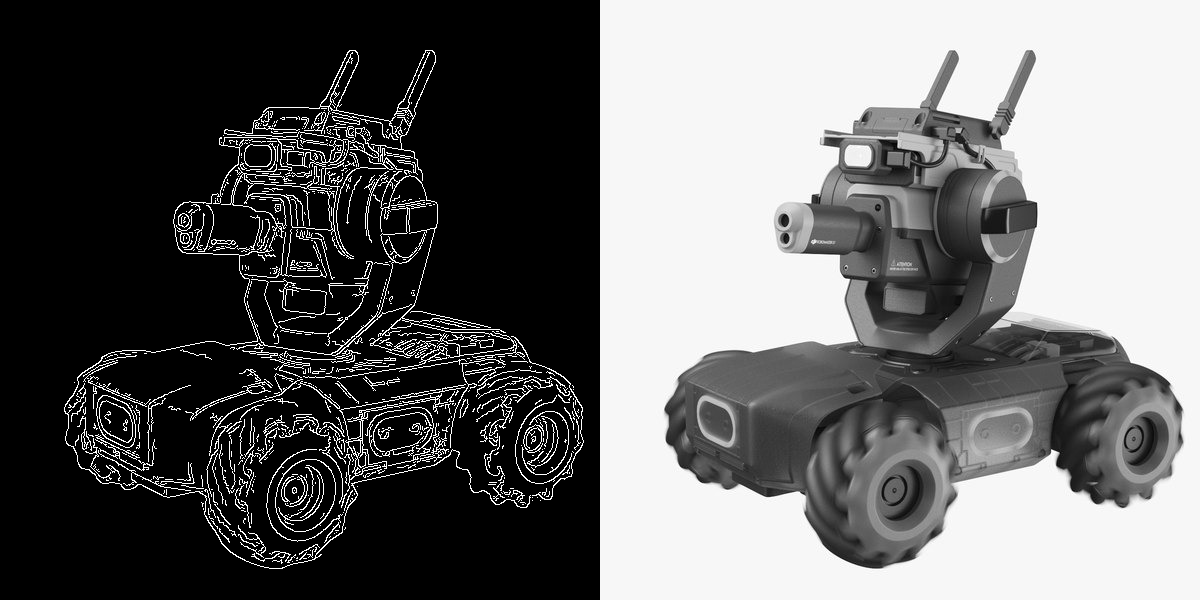

In [3]:
import cv2
import numpy as np

from PIL import Image

lower = 30  # 最小阈值
upper = 70  # 最大阈值

img_path = '1-2.jpg'  # 指定测试图像路径

gray = cv2.imread(img_path, 0)  # 读取灰度图像
edge = cv2.Canny(gray, lower, upper) # Canny 图像边缘检测

contrast = np.concatenate([edge, gray], 1) # 图像拼接
Image.fromarray(contrast) # 显示图像

## **基于 Numpy 模块实现简单的 Canny 边缘检测器**

### 0. 导入必要的包

In [4]:
import cv2
import math
import numpy as np

### 1. 高斯模糊

In [5]:
def smooth(img_gray, kernel_size=5):
    # 生成高斯滤波器
    """
    要生成一个 (2k+1)x(2k+1) 的高斯滤波器，滤波器的各个元素计算公式如下：

    H[i, j] = (1/(2*pi*sigma**2))*exp(-1/2*sigma**2((i-k-1)**2 + (j-k-1)**2))
    """
    sigma1 = sigma2 = 1.4
    gau_sum = 0
    gaussian = np.zeros([kernel_size, kernel_size])
    for i in range(kernel_size):
        for j in range(kernel_size):
            gaussian[i, j] = math.exp(
                (-1 / (2 * sigma1 * sigma2)) *
                (np.square(i - 3) + np.square(j-3))
            ) / (2 * math.pi * sigma1 * sigma2)
            gau_sum = gau_sum + gaussian[i, j]

    # 归一化处理
    gaussian = gaussian / gau_sum

    # 高斯滤波

    img_gray = np.pad(img_gray, ((kernel_size//2, kernel_size//2), (kernel_size//2, kernel_size//2)), mode='constant')
    W, H = img_gray.shape
    new_gray = np.zeros([W - kernel_size, H - kernel_size])

    for i in range(W-kernel_size):
        for j in range(H-kernel_size):
            new_gray[i, j] = np.sum(
                img_gray[i: i + kernel_size, j: j + kernel_size] * gaussian
            )

    return new_gray

### 2. 计算图像的梯度幅值

In [6]:
def gradients(new_gray):
    """
    :type: image which after smooth
    :rtype:
        dx: gradient in the x direction
        dy: gradient in the y direction
        M: gradient magnitude
        theta: gradient direction
    """

    W, H = new_gray.shape
    dx = np.zeros([W-1, H-1])
    dy = np.zeros([W-1, H-1])
    M = np.zeros([W-1, H-1])
    theta = np.zeros([W-1, H-1])

    for i in range(W-1):
        for j in range(H-1):
            dx[i, j] = new_gray[i+1, j] - new_gray[i, j]
            dy[i, j] = new_gray[i, j+1] - new_gray[i, j]
            # 图像梯度幅值作为图像强度值
            M[i, j] = np.sqrt(np.square(dx[i, j]) + np.square(dy[i, j]))
            # 计算  θ - artan(dx/dy)
            theta[i, j] = math.atan(dx[i, j] / (dy[i, j] + 0.000000001))

    return dx, dy, M, theta

### 3. 非极大值抑制

In [7]:
def NMS(M, dx, dy):

    d = np.copy(M)
    W, H = M.shape
    NMS = np.copy(d)
    NMS[0, :] = NMS[W-1, :] = NMS[:, 0] = NMS[:, H-1] = 0

    for i in range(1, W-1):
        for j in range(1, H-1):

            # 如果当前梯度为0，该点就不是边缘点
            if M[i, j] == 0:
                NMS[i, j] = 0

            else:
                gradX = dx[i, j]  # 当前点 x 方向导数
                gradY = dy[i, j]  # 当前点 y 方向导数
                gradTemp = d[i, j]  # 当前梯度点

                # 如果 y 方向梯度值比较大，说明导数方向趋向于 y 分量
                if np.abs(gradY) > np.abs(gradX):
                    weight = np.abs(gradX) / np.abs(gradY)  # 权重
                    grad2 = d[i-1, j]
                    grad4 = d[i+1, j]

                    # 如果 x, y 方向导数符号一致
                    # 像素点位置关系
                    # g1 g2
                    #    c
                    #    g4 g3
                    if gradX * gradY > 0:
                        grad1 = d[i-1, j-1]
                        grad3 = d[i+1, j+1]

                    # 如果 x，y 方向导数符号相反
                    # 像素点位置关系
                    #    g2 g1
                    #    c
                    # g3 g4
                    else:
                        grad1 = d[i-1, j+1]
                        grad3 = d[i+1, j-1]

                # 如果 x 方向梯度值比较大
                else:
                    weight = np.abs(gradY) / np.abs(gradX)
                    grad2 = d[i, j-1]
                    grad4 = d[i, j+1]

                    # 如果 x, y 方向导数符号一致
                    # 像素点位置关系
                    #      g3
                    # g2 c g4
                    # g1
                    if gradX * gradY > 0:

                        grad1 = d[i+1, j-1]
                        grad3 = d[i-1, j+1]

                    # 如果 x，y 方向导数符号相反
                    # 像素点位置关系
                    # g1
                    # g2 c g4
                    #      g3
                    else:
                        grad1 = d[i-1, j-1]
                        grad3 = d[i+1, j+1]

                # 利用 grad1-grad4 对梯度进行插值
                gradTemp1 = weight * grad1 + (1 - weight) * grad2
                gradTemp2 = weight * grad3 + (1 - weight) * grad4

                # 当前像素的梯度是局部的最大值，可能是边缘点
                if gradTemp >= gradTemp1 and gradTemp >= gradTemp2:
                    NMS[i, j] = gradTemp

                else:
                    # 不可能是边缘点
                    NMS[i, j] = 0

    return NMS

### 4. 图像二值化和边缘连接

In [8]:
def double_threshold(NMS, threshold1, threshold2):
    NMS = np.pad(NMS, ((1, 1), (1, 1)), mode='constant')
    W, H = NMS.shape
    DT = np.zeros([W, H])

    # 定义高低阈值
    TL = threshold1  * np.max(NMS)
    TH = threshold2  * np.max(NMS)

    for i in range(1, W-1):
        for j in range(1, H-1):
           # 双阈值选取
            if (NMS[i, j] < TL):
                DT[i, j] = 0

            elif (NMS[i, j] > TH):
                DT[i, j] = 1

           # 连接
            elif ((NMS[i-1, j-1:j+1] < TH).any() or
                    (NMS[i+1, j-1:j+1].any() or
                     (NMS[i, [j-1, j+1]] < TH).any())):
                DT[i, j] = 1

    return DT

### 5. Canny 边缘检测

In [9]:
def canny(gray, threshold1, threshold2, kernel_size=5):
    norm_gray = gray
    gray_smooth = smooth(norm_gray, kernel_size)
    dx, dy, M, theta = gradients(gray_smooth)
    nms = NMS(M, dx, dy)
    DT = double_threshold(nms, threshold1, threshold2)
    return DT

### 6. 代码测试

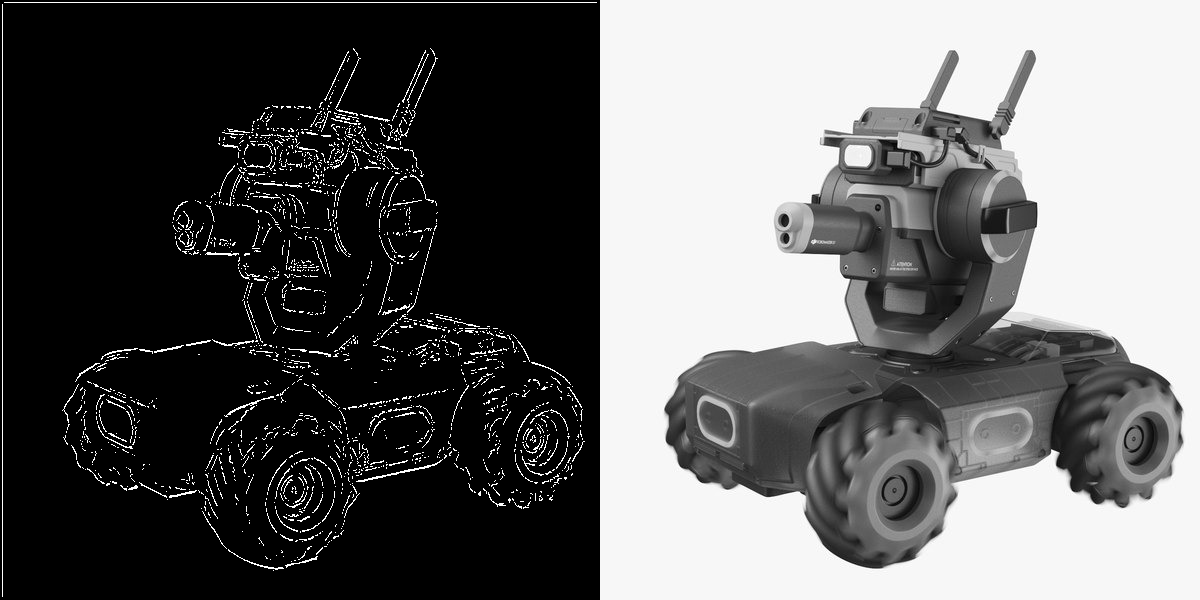

In [10]:
import cv2
import numpy as np

from PIL import Image

lower = 0.1 # 最小阈值
upper = 0.3 # 最大阈值

img_path = '1-2.jpg' # 指定测试图像路径

gray = cv2.imread(img_path, 0) # 读取灰度图像
edge = canny(gray, lower, upper) # Canny 图像边缘检测
edge = (edge * 255).astype(np.uint8) # 反归一化

contrast = np.concatenate([edge, gray], 1) # 图像拼接
Image.fromarray(contrast) # 显示图像

## 基于 Pytorch 实现的 Canny 边缘检测器

### 0. 导入必要的模块

In [11]:
import torch
import torch.nn as nn

import cv2
import math
import numpy as np

from scipy.signal import gaussian

### 1. 卷积参数设置

In [12]:
def get_state_dict(filter_size=5, std=1.0, map_func=lambda x:x):
    # 高斯卷积核
    generated_filters = gaussian(filter_size, std=std).reshape([1, filter_size]).astype(np.float32)
    gaussian_filter_horizontal = generated_filters[None, None, ...]
    gaussian_filter_vertical = generated_filters.T[None, None, ...]

    # Sobel 卷积核
    sobel_filter_horizontal = np.array([[[
        [1., 0., -1.], 
        [2., 0., -2.],
        [1., 0., -1.]]]], 
        dtype=np.float32
    )
    sobel_filter_vertical = np.array([[[
        [1., 2., 1.], 
        [0., 0., 0.], 
        [-1., -2., -1.]]]], 
        dtype=np.float32
    )
    
    # 方向卷积核
    directional_filter = np.array(
        [[[[ 0.,  0.,  0.],
          [ 0.,  1., -1.],
          [ 0.,  0.,  0.]]],

        [[[ 0.,  0.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0., -1.]]],

        [[[ 0.,  0.,  0.],
          [ 0.,  1.,  0.],
          [ 0., -1.,  0.]]],

        [[[ 0.,  0.,  0.],
          [ 0.,  1.,  0.],
          [-1.,  0.,  0.]]],

        [[[ 0.,  0.,  0.],
          [-1.,  1.,  0.],
          [ 0.,  0.,  0.]]],

        [[[-1.,  0.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  0.]]],

        [[[ 0., -1.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  0.]]],

        [[[ 0.,  0., -1.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  0.]]]], 
        dtype=np.float32
    )

    # 连通卷积核
    connect_filter = np.array([[[
        [1., 1., 1.], 
        [1., 0., 1.], 
        [1., 1., 1.]]]],
        dtype=np.float32
    )

    return {
        'gaussian_filter_horizontal.weight': map_func(gaussian_filter_horizontal),
        'gaussian_filter_vertical.weight': map_func(gaussian_filter_vertical),
        'sobel_filter_horizontal.weight': map_func(sobel_filter_horizontal),
        'sobel_filter_vertical.weight': map_func(sobel_filter_vertical),
        'directional_filter.weight': map_func(directional_filter),
        'connect_filter.weight': map_func(connect_filter)
    }

### 2. Canny 检测器

In [13]:
class CannyDetector(nn.Module):
    def __init__(self, filter_size=5, std=1.0, device='cpu'):
        super(CannyDetector, self).__init__()
        # 配置运行设备
        self.device = device

        # 高斯滤波器
        self.gaussian_filter_horizontal = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,filter_size), padding=(0,filter_size//2), bias=False)
        self.gaussian_filter_vertical = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(filter_size,1), padding=(filter_size//2,0), bias=False)

        # Sobel 滤波器
        self.sobel_filter_horizontal = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)
        self.sobel_filter_vertical = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)

        # 定向滤波器
        self.directional_filter = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, bias=False)

        # 连通滤波器
        self.connect_filter = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)

        # 初始化参数
        params = get_state_dict(filter_size=filter_size, std=std, map_func=lambda x:torch.from_numpy(x).to(self.device))
        self.load_state_dict(params)

    @torch.no_grad()
    def forward(self, img, threshold1=10.0, threshold2=100.0):
        # 拆分图像通道
        img_r = img[:,0:1] # red channel
        img_g = img[:,1:2] # green channel
        img_b = img[:,2:3] # blue channel

        # Step1: 应用高斯滤波进行模糊降噪
        blur_horizontal = self.gaussian_filter_horizontal(img_r)
        blurred_img_r = self.gaussian_filter_vertical(blur_horizontal)
        blur_horizontal = self.gaussian_filter_horizontal(img_g)
        blurred_img_g = self.gaussian_filter_vertical(blur_horizontal)
        blur_horizontal = self.gaussian_filter_horizontal(img_b)
        blurred_img_b = self.gaussian_filter_vertical(blur_horizontal)

        # Step2: 用 Sobel 算子求图像的强度梯度
        grad_x_r = self.sobel_filter_horizontal(blurred_img_r)
        grad_y_r = self.sobel_filter_vertical(blurred_img_r)
        grad_x_g = self.sobel_filter_horizontal(blurred_img_g)
        grad_y_g = self.sobel_filter_vertical(blurred_img_g)
        grad_x_b = self.sobel_filter_horizontal(blurred_img_b)
        grad_y_b = self.sobel_filter_vertical(blurred_img_b)

        # Step2: 确定边缘梯度和方向
        grad_mag = torch.sqrt(grad_x_r**2 + grad_y_r**2)
        grad_mag += torch.sqrt(grad_x_g**2 + grad_y_g**2)
        grad_mag += torch.sqrt(grad_x_b**2 + grad_y_b**2)
        grad_orientation = (torch.atan2(grad_y_r+grad_y_g+grad_y_b, grad_x_r+grad_x_g+grad_x_b) * (180.0/math.pi))
        grad_orientation += 180.0
        grad_orientation =  torch.round(grad_orientation / 45.0) * 45.0

        # Step3: 非最大抑制，边缘细化
        all_filtered = self.directional_filter(grad_mag)

        inidices_positive = (grad_orientation / 45) % 8
        inidices_negative = ((grad_orientation / 45) + 4) % 8
    
        channel_select_filtered_positive = torch.gather(all_filtered, 1, inidices_positive.long())
        channel_select_filtered_negative = torch.gather(all_filtered, 1, inidices_negative.long())

        channel_select_filtered = torch.stack([channel_select_filtered_positive, channel_select_filtered_negative])

        is_max = channel_select_filtered.min(dim=0)[0] > 0.0

        thin_edges = grad_mag.clone()
        thin_edges[is_max==0] = 0.0

        # Step4: 双阈值
        low_threshold = min(threshold1, threshold2)
        high_threshold = max(threshold1, threshold2)
        thresholded = thin_edges.clone()
        lower = thin_edges<low_threshold
        thresholded[lower] = 0.0
        higher = thin_edges>high_threshold
        thresholded[higher] = 1.0
        connect_map = self.connect_filter(higher.float())
        middle = torch.logical_and(thin_edges>=low_threshold, thin_edges<=high_threshold)
        thresholded[middle] = 0.0
        connect_map[torch.logical_not(middle)] = 0
        thresholded[connect_map>0] = 1.0
        thresholded[..., 0, :] = 0.0
        thresholded[..., -1, :] = 0.0
        thresholded[..., :, 0] = 0.0
        thresholded[..., :, -1] = 0.0
        thresholded = (thresholded>0.0).float()

        return thresholded

### 3. 代码测试

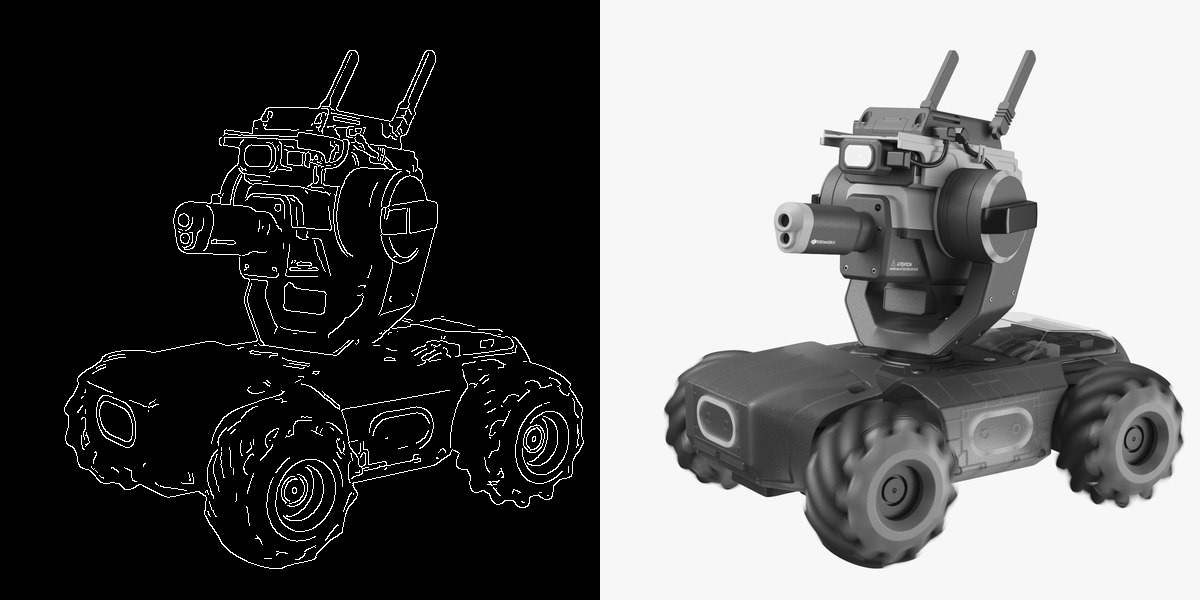

In [14]:
import cv2
import torch
import numpy as np

from PIL import Image

lower = 2.5  # 最小阈值
upper = 5  # 最大阈值

img_path = '1-2.jpg'  # 指定测试图像路径

img = cv2.imread(img_path, 1)  # 读取彩色图像
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 转为灰度图
img = np.transpose(img, [2, 1, 0]) / 255.0 # 转置 + 归一化
img_tensor = torch.from_numpy(img[None, ...]).float() # 转换为 Tensor

canny = CannyDetector(device='cpu') # 初始化 Canny 检测器，可设置其运行的设备

edge = canny(img_tensor, lower, upper)  # Canny 图像边缘检测
edge = np.squeeze(edge.cpu().numpy()) # 去除 Batch dim
edge = np.transpose(edge, [1, 0]) # 图像转置
edge = (edge * 255).astype(np.uint8)  # 反归一化

contrast = np.concatenate([edge, gray], 1) # 图像拼接
Image.fromarray(contrast) # 显示图像

## 基于 Paddle 实现的 Canny 边缘检测器

### 0. 导入必要的模块

In [15]:
import paddle
import paddle.nn as nn

import cv2
import math
import numpy as np

from scipy.signal import gaussian

### 1. 卷积参数设置

In [16]:
def get_state_dict(filter_size=5, std=1.0, map_func=lambda x:x):
    # 高斯卷积核
    generated_filters = gaussian(filter_size, std=std).reshape([1, filter_size]).astype(np.float32)
    gaussian_filter_horizontal = generated_filters[None, None, ...]
    gaussian_filter_vertical = generated_filters.T[None, None, ...]

    # Sobel 卷积核
    sobel_filter_horizontal = np.array([[[
        [1., 0., -1.], 
        [2., 0., -2.],
        [1., 0., -1.]]]], 
        dtype=np.float32
    )
    sobel_filter_vertical = np.array([[[
        [1., 2., 1.], 
        [0., 0., 0.], 
        [-1., -2., -1.]]]], 
        dtype=np.float32
    )
    
    # 方向卷积核
    directional_filter = np.array(
        [[[[ 0.,  0.,  0.],
          [ 0.,  1., -1.],
          [ 0.,  0.,  0.]]],

        [[[ 0.,  0.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0., -1.]]],

        [[[ 0.,  0.,  0.],
          [ 0.,  1.,  0.],
          [ 0., -1.,  0.]]],

        [[[ 0.,  0.,  0.],
          [ 0.,  1.,  0.],
          [-1.,  0.,  0.]]],

        [[[ 0.,  0.,  0.],
          [-1.,  1.,  0.],
          [ 0.,  0.,  0.]]],

        [[[-1.,  0.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  0.]]],

        [[[ 0., -1.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  0.]]],

        [[[ 0.,  0., -1.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  0.]]]], 
        dtype=np.float32
    )

    # 连通卷积核
    connect_filter = np.array([[[
        [1., 1., 1.], 
        [1., 0., 1.], 
        [1., 1., 1.]]]],
        dtype=np.float32
    )

    return {
        'gaussian_filter_horizontal.weight': map_func(gaussian_filter_horizontal),
        'gaussian_filter_vertical.weight': map_func(gaussian_filter_vertical),
        'sobel_filter_horizontal.weight': map_func(sobel_filter_horizontal),
        'sobel_filter_vertical.weight': map_func(sobel_filter_vertical),
        'directional_filter.weight': map_func(directional_filter),
        'connect_filter.weight': map_func(connect_filter)
    }

### 2. Canny 检测器

In [17]:
class CannyDetector(nn.Layer):
    def __init__(self, filter_size=5, std=1.0):
        super(CannyDetector, self).__init__()
        # 高斯滤波器
        self.gaussian_filter_horizontal = nn.Conv2D(in_channels=1, out_channels=1, kernel_size=(1,filter_size), padding=(0,filter_size//2), bias_attr=False)
        self.gaussian_filter_vertical = nn.Conv2D(in_channels=1, out_channels=1, kernel_size=(filter_size,1), padding=(filter_size//2,0), bias_attr=False)

        # # Sobel 滤波器
        self.sobel_filter_horizontal = nn.Conv2D(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias_attr=False)
        self.sobel_filter_vertical = nn.Conv2D(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias_attr=False)

        # 定向滤波器
        self.directional_filter = nn.Conv2D(in_channels=1, out_channels=8, kernel_size=3, padding=1, bias_attr=False)

        # 连通滤波器
        self.connect_filter = nn.Conv2D(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias_attr=False)

        # 初始化参数
        self.set_dict(get_state_dict(filter_size=filter_size, std=std))

    @paddle.no_grad()
    def forward(self, img, threshold1, threshold2):
        # 拆分图像通道
        img_r = img[:,0:1] # red channel
        img_g = img[:,1:2] # green channel
        img_b = img[:,2:3] # blue channel

        # Step1: 应用高斯滤波进行模糊降噪
        blur_horizontal = self.gaussian_filter_horizontal(img_r)
        blurred_img_r = self.gaussian_filter_vertical(blur_horizontal)
        blur_horizontal = self.gaussian_filter_horizontal(img_g)
        blurred_img_g = self.gaussian_filter_vertical(blur_horizontal)
        blur_horizontal = self.gaussian_filter_horizontal(img_b)
        blurred_img_b = self.gaussian_filter_vertical(blur_horizontal)

        # Step2: 用 Sobel 算子求图像的强度梯度
        grad_x_r = self.sobel_filter_horizontal(blurred_img_r)
        grad_y_r = self.sobel_filter_vertical(blurred_img_r)
        grad_x_g = self.sobel_filter_horizontal(blurred_img_g)
        grad_y_g = self.sobel_filter_vertical(blurred_img_g)
        grad_x_b = self.sobel_filter_horizontal(blurred_img_b)
        grad_y_b = self.sobel_filter_vertical(blurred_img_b)

        # Step2: 确定边缘梯度和方向
        grad_mag = paddle.sqrt(grad_x_r**2 + grad_y_r**2)
        grad_mag += paddle.sqrt(grad_x_g**2 + grad_y_g**2)
        grad_mag += paddle.sqrt(grad_x_b**2 + grad_y_b**2)
        grad_orientation = (paddle.atan2(grad_y_r+grad_y_g+grad_y_b, grad_x_r+grad_x_g+grad_x_b) * (180.0/math.pi))
        grad_orientation += 180.0
        grad_orientation =  paddle.round(grad_orientation / 45.0) * 45.0

        # Step3: 非最大抑制，边缘细化
        all_filtered = self.directional_filter(grad_mag)

        inidices_positive = (grad_orientation / 45) % 8
        inidices_negative = ((grad_orientation / 45) + 4) % 8

        paddle.cast(inidices_positive, 'int64')
        paddle.cast(inidices_negative, 'int64')
    
        channel_select_filtered_positive = paddle.gather(all_filtered, inidices_positive, 1 )
        channel_select_filtered_negative = paddle.gather(all_filtered, inidices_negative, 1)

        channel_select_filtered = paddle.stack([channel_select_filtered_positive, channel_select_filtered_negative])

        is_max = channel_select_filtered.min(axis=0) > 0.0

        thin_edges = grad_mag.clone()
        thin_edges[is_max==0] = 0.0

        # Step4: 双阈值
        low_threshold = min(threshold1, threshold2)
        high_threshold = max(threshold1, threshold2)
        thresholded = thin_edges.clone()
        lower = thin_edges<low_threshold
        thresholded[lower] = 0.0
        higher = thin_edges>high_threshold
        thresholded[higher] = 1.0
        connect_map = self.connect_filter(higher.astype('float32'))
        middle = paddle.logical_and(thin_edges>=low_threshold, thin_edges<=high_threshold)
        thresholded[middle] = 0.0
        connect_map[paddle.logical_not(middle)] = 0
        thresholded[connect_map>0] = 1.0
        thresholded[..., 0, :] = 0.0
        thresholded[..., -1, :] = 0.0
        thresholded[..., :, 0] = 0.0
        thresholded[..., :, -1] = 0.0
        thresholded = (thresholded>0.0).cast('float32')

        return thresholded

### 3. 代码测试

/usr/local/lib/python3.7/dist-packages/paddle/fluid/layers/tensor.py:624: UserWarning: paddle.assign doesn't support float64 input now due to current platform protobuf data limitation, we convert it to float32
  "paddle.assign doesn't support float64 input now due "


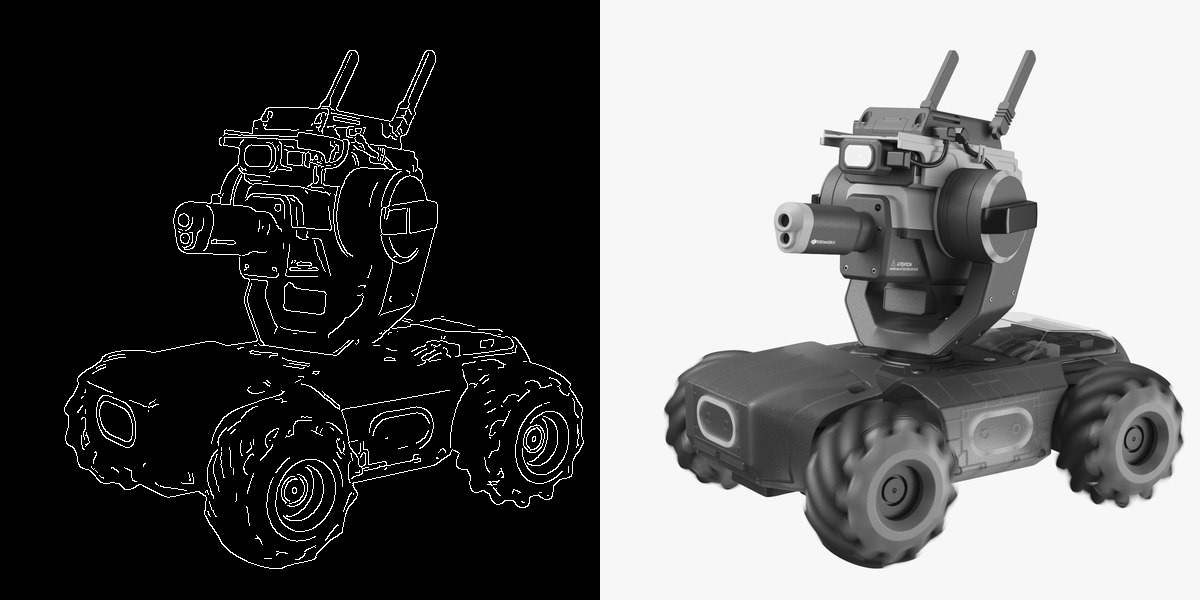

In [18]:
import cv2
import paddle
import numpy as np

from PIL import Image

lower = 2.5  # 最小阈值
upper = 5  # 最大阈值

img_path = '1-2.jpg'  # 指定测试图像路径

img = cv2.imread(img_path, 1)  # 读取彩色图像
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 转为灰度图

img = np.transpose(img, [2, 1, 0]) / 255.0 # 转置 + 归一化
img_tensor = paddle.to_tensor(img[None, ...], dtype='float32') # 转换为 Tensor

paddle.set_device('cpu') # 设置其运行的设备
canny = CannyDetector() # 初始化 Canny 检测器

edge = canny(img_tensor, lower, upper)  # Canny 图像边缘检测
edge = np.squeeze(edge.numpy()) # 去除 Batch dim
edge = np.transpose(edge, [1, 0]) # 图像转置
edge = (edge * 255).astype(np.uint8)  # 反归一化

contrast = np.concatenate([edge, gray], 1) # 图像拼接
Image.fromarray(contrast) # 显示图像

## 完整项目
* 本项目的所有代码也整合开源到了 Github

* 项目地址：[jm12138/CannyDetector](https://github.com/jm12138/CannyDetector)

* 包含上述的三个版本的实现

### 0. 同步代码
* 可通过如下命令同步代码库

In [ ]:
!git clone https://github.com/jm12138/CannyDetector

### 1. 目录结构
* 本项目大致的文件目录结构及功能如下：

    ```bash
    │ requirements.txt # 依赖模块列表
    │
    ├─tools # 脚本工具
    │  │ 
    │  ├─test_all.py # 总体测试脚本
    │  │ 
    │  ├─test_opencv.py # OpenCV 测试脚本
    │  │ 
    │  ├─test_paddle.py # Paddle 测试脚本
    │  │ 
    │  ├─test_python.py # Python 测试脚本
    │  │ 
    │  └─test_pytorch.py # Pytorch 测试脚本
    │  
    ├─cannydet # Canny 边缘检测器代码
    │  │ 
    │  ├─paddle # Paddle 实现
    │  │          
    │  ├─python # Python 实现
    │  │          
    │  └─torch # Pytorch 实现
    │          
    ├─results # 输出结果
    │  │ 
    │  ├─compare # 结果对比图像
    │  │ 
    │  ├─cv2 # OpenCV 输出图像
    │  │ 
    │  ├─paddle # Paddle 输出图像
    │  │          
    │  ├─python # Python 输出图像
    │  │          
    │  └─torch # Pytorch 输出图像
    │      
    └─test_imgs # 测试图像
    ```

### 2. 运行测试

* 切换至代码目录

In [ ]:
%cd /content/CannyDetector

* 测试 Numpy 版本实现

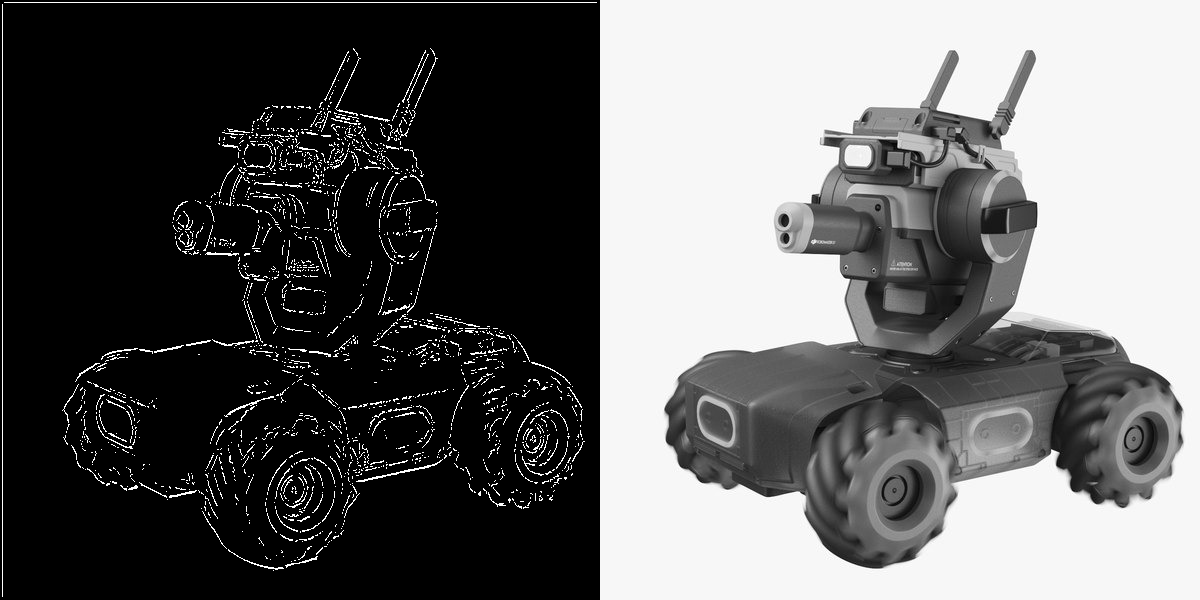

In [22]:
import cv2
import numpy as np

from PIL import Image
from cannydet.python import canny

lower = 0.1 # 最小阈值
upper = 0.3 # 最大阈值

img_path = 'test_imgs/1-2.jpg' # 指定测试图像路径

gray = cv2.imread(img_path, 0) # 读取灰度图像
edge = canny(gray, lower, upper) # Canny 图像边缘检测
edge = (edge * 255).astype(np.uint8) # 反归一化

contrast = np.concatenate([edge, gray], 1) # 图像拼接
Image.fromarray(contrast) # 显示图像

* 测试 Pytorch 版本实现

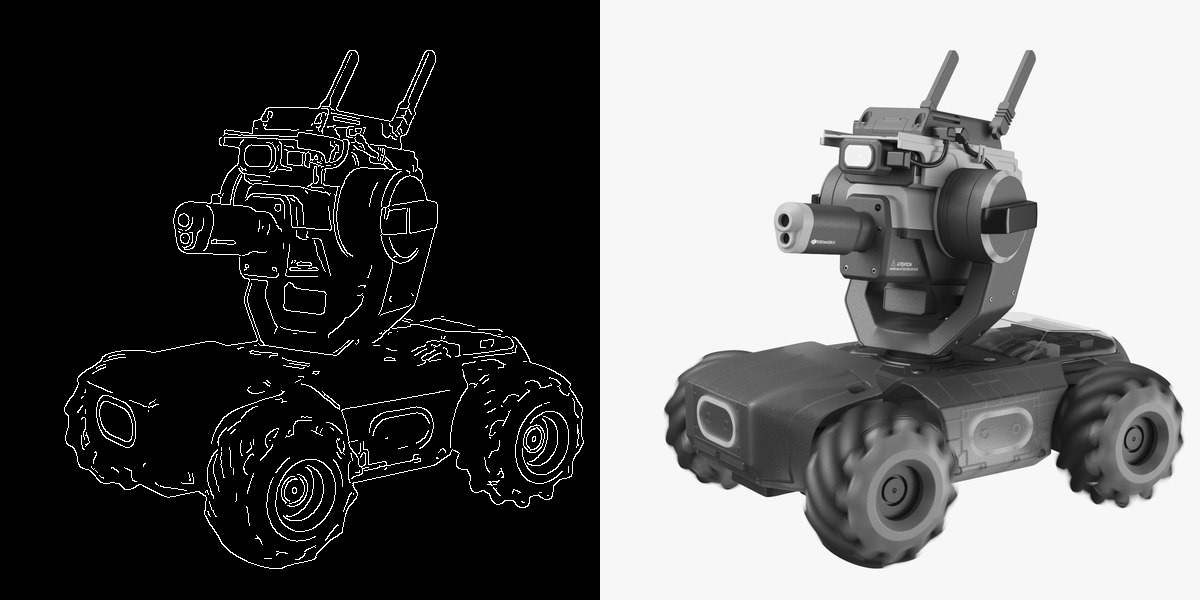

In [23]:
import cv2
import torch
import numpy as np

from PIL import Image
from cannydet.torch import CannyDetector

lower = 2.5  # 最小阈值
upper = 5  # 最大阈值

img_path = 'test_imgs/1-2.jpg'  # 指定测试图像路径

img = cv2.imread(img_path, 1)  # 读取彩色图像
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 转为灰度图
img = np.transpose(img, [2, 1, 0]) / 255.0 # 转置 + 归一化
img_tensor = torch.from_numpy(img[None, ...]).float() # 转换为 Tensor

canny = CannyDetector(device='cpu') # 初始化 Canny 检测器，可设置其运行的设备

edge = canny(img_tensor, lower, upper)  # Canny 图像边缘检测
edge = np.squeeze(edge.cpu().numpy()) # 去除 Batch dim
edge = np.transpose(edge, [1, 0]) # 图像转置
edge = (edge * 255).astype(np.uint8)  # 反归一化

contrast = np.concatenate([edge, gray], 1) # 图像拼接
Image.fromarray(contrast) # 显示图像

* 测试 Paddle 版本实现

/content/CannyDetector


/usr/local/lib/python3.7/dist-packages/paddle/fluid/layers/tensor.py:624: UserWarning: paddle.assign doesn't support float64 input now due to current platform protobuf data limitation, we convert it to float32
  "paddle.assign doesn't support float64 input now due "


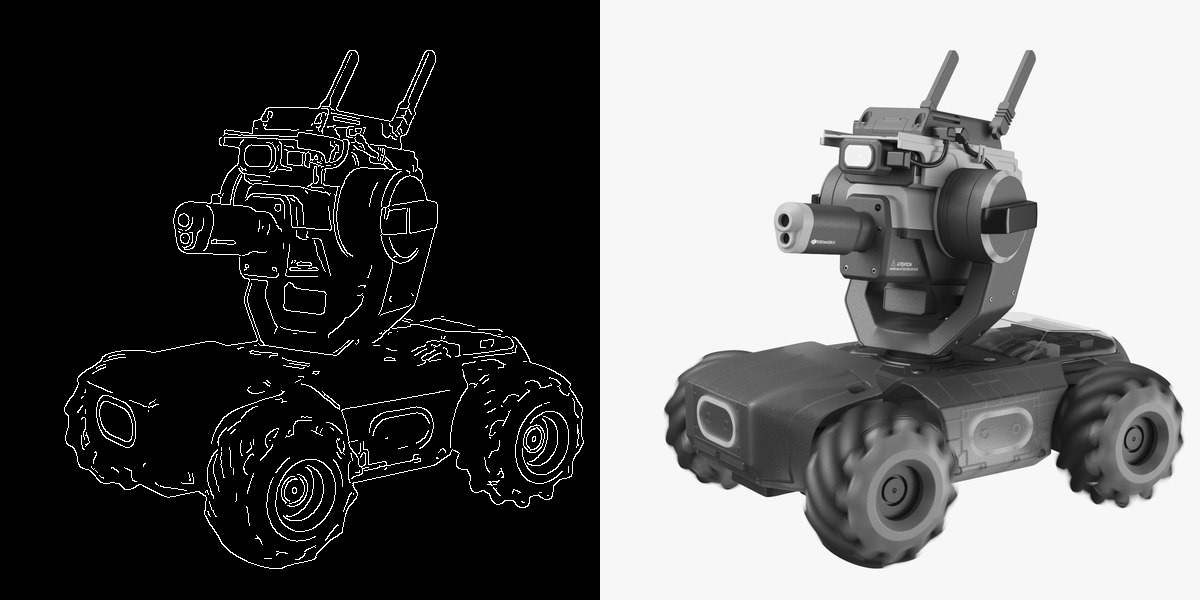

In [21]:
import cv2
import paddle
import numpy as np

from PIL import Image
from cannydet.paddle import CannyDetector

lower = 2.5  # 最小阈值
upper = 5  # 最大阈值

img_path = 'test_imgs/1-2.jpg'  # 指定测试图像路径

img = cv2.imread(img_path, 1)  # 读取彩色图像
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 转为灰度图 
img = np.transpose(img, [2, 1, 0]) / 255.0 # 转置 + 归一化
img_tensor = paddle.to_tensor(img[None, ...]).cast('float32') # 转换为 Tensor

paddle.set_device('cpu') # 设置其运行的设备
canny = CannyDetector() # 初始化 Canny 检测器

edge = canny(img_tensor, lower, upper)  # Canny 图像边缘检测
edge = np.squeeze(edge.numpy()) # 去除 Batch dim
edge = np.transpose(edge, [1, 0]) # 图像转置
edge = (edge * 255).astype(np.uint8)  # 反归一化

contrast = np.concatenate([edge, gray], 1) # 图像拼接
Image.fromarray(contrast) # 显示图像

# **总结**
* 简单介绍并使用 Numpy / Pytorch 和 Paddle 实现了 Canny 边缘检测算法